In [1]:
import pandas as pd
import numpy as np
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination
import warnings
warnings.filterwarnings('ignore')

d:\main_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('datasets/training.csv')
data = data.dropna()
for col in data.columns:
    data[col] = data[col].astype(str)


In [3]:
def preprocess_data(df, min_occurrence_rate=0.01):
    disease_col = 'prognosis'
    medicine_col = 'medicine'
    
    # Get symptom columns (exclude disease and medicine)
    symptom_cols = [col for col in df.columns if col not in [disease_col, medicine_col]]
    
    # Remove symptoms that occur in less than min_occurrence_rate of cases
    min_count = int(min_occurrence_rate * len(df))
    informative_symptoms = []
    
    for symptom in symptom_cols:
        if df[symptom].astype(int).sum() >= min_count:
            # Also ensure the symptom has both 0 and 1 values
            if len(df[symptom].unique()) > 1:
                informative_symptoms.append(symptom)
    
    print(f"Original symptoms: {len(symptom_cols)}")
    print(f"Informative symptoms kept: {len(informative_symptoms)}")
    
    # Keep only informative symptoms + disease + medicine
    final_cols = informative_symptoms + [disease_col, medicine_col]
    return df[final_cols], informative_symptoms


In [4]:
data_clean, symptom_columns = preprocess_data(data)

Original symptoms: 134
Informative symptoms kept: 132


In [24]:
def create_improved_hierarchical_structure():
    """Create a hierarchical Bayesian network structure with medical system clusters"""
    
    # Define medical system clusters based on medical knowledge
    medical_systems = {
        'respiratory_system': [
            'cough', 'breathlessness', 'chest_pain', 'phlegm', 'throat_irritation',
            'continuous_sneezing', 'runny_nose', 'congestion', 'mucoid_sputum', 'blood_in_sputum'
        ],
        'digestive_system': [
            'nausea', 'vomiting', 'diarrhoea', 'constipation', 'stomach_pain', 'acidity',
            'abdominal_pain', 'belly_pain', 'passage_of_gases', 'pain_during_bowel_movements',
            'bloody_stool', 'yellow_urine', 'yellowing_of_eyes'
        ],
        'neurological_system': [
            'headache', 'dizziness', 'neck_pain', 'back_pain', 'muscle_weakness',
            'weakness_in_limbs', 'loss_of_balance', 'altered_sensorium', 'slurred_speech'
        ],
        'systemic_symptoms': [
            'fatigue', 'high_fever', 'weight_loss', 'sweating', 'chills', 'lethargy',
            'malaise', 'loss_of_appetite', 'dehydration', 'sunken_eyes'
        ],
        'skin_system': [
            'itching', 'skin_rash', 'yellowish_skin', 'red_spots_over_body',
            'patches_in_throat', 'blister', 'skin_peeling'
        ],
        'musculoskeletal_system': [
            'joint_pain', 'muscle_pain', 'cramps', 'knee_pain', 'hip_joint_pain',
            'stiff_neck', 'swelling_joints', 'movement_stiffness'
        ]
    }
    
    # Create system cluster columns
    print("Creating medical system clusters...")
    for system_name, symptoms in medical_systems.items():
        # Find available symptoms in data
        available_symptoms = [s for s in symptoms if s in data_clean.columns]
        if available_symptoms:
            # Create cluster: 1 if any symptom in the system is present
            data_clean[system_name] = data_clean[available_symptoms].astype(int).max(axis=1).astype(str)
            print(f"  {system_name}: {len(available_symptoms)} symptoms")
        else:
            print(f"  {system_name}: No symptoms found in data")
    
    # Create severity indicator
    critical_symptoms = [
        'high_fever', 'breathlessness', 'chest_pain', 'altered_sensorium', 
        'acute_liver_failure', 'yellowing_of_eyes', 'blood_in_sputum'
    ]
    available_critical = [s for s in critical_symptoms if s in data_clean.columns]
    if available_critical:
        data_clean['critical_condition'] = data_clean[available_critical].astype(int).max(axis=1).astype(str)
        print(f"  critical_condition: {len(available_critical)} symptoms")
    
    # Build hierarchical network structure
    edges = []
    
    # Level 1: Disease → Medical Systems + Critical Condition
    system_nodes = []
    for system_name in medical_systems.keys():
        if system_name in data_clean.columns:
            edges.append(('prognosis', system_name))
            system_nodes.append(system_name)
    
    if 'critical_condition' in data_clean.columns:
        edges.append(('prognosis', 'critical_condition'))
        system_nodes.append('critical_condition')
    
    # Level 2: Medical Systems → Key Symptoms (not all symptoms)
    key_symptoms_per_system = {
        'respiratory_system': ['cough', 'breathlessness', 'chest_pain'],
        'digestive_system': ['nausea', 'vomiting', 'stomach_pain', 'diarrhoea'],
        'neurological_system': ['headache', 'dizziness', 'weakness_in_limbs'],
        'systemic_symptoms': ['fatigue', 'high_fever', 'weight_loss'],
        'skin_system': ['itching', 'skin_rash', 'yellowish_skin'],
        'musculoskeletal_system': ['joint_pain', 'muscle_pain']
    }
    
    for system_name, key_symptoms in key_symptoms_per_system.items():
        if system_name in data_clean.columns:
            for symptom in key_symptoms:
                if symptom in data_clean.columns:
                    edges.append((system_name, symptom))
    
    # Critical condition to critical symptoms
    if 'critical_condition' in data_clean.columns:
        critical_to_symptoms = ['high_fever', 'breathlessness', 'altered_sensorium']
        for symptom in critical_to_symptoms:
            if symptom in data_clean.columns:
                edges.append(('critical_condition', symptom))
    
    # Disease → Medicine (direct relationship)
    edges.append(('prognosis', 'medicine'))
    
    print(f"\nHierarchical structure created:")
    print(f"  Total edges: {len(edges)}")
    print(f"  System nodes: {len(system_nodes)}")
    
    return edges, system_nodes

# Create the improved structure
edges_improved, system_nodes = create_improved_hierarchical_structure()

Creating medical system clusters...
  respiratory_system: 10 symptoms
  digestive_system: 13 symptoms
  neurological_system: 9 symptoms
  systemic_symptoms: 10 symptoms
  skin_system: 7 symptoms
  musculoskeletal_system: 8 symptoms
  critical_condition: 7 symptoms

Hierarchical structure created:
  Total edges: 29
  System nodes: 7


In [25]:
print("\nBuilding improved hierarchical model...")
model_improved = DiscreteBayesianNetwork(edges_improved)
model_improved.fit(data_clean, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=10)
infer_improved = VariableElimination(model_improved)
print("Model training completed!")

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'itching': 'C', 'skin_rash': 'C', 'nodal_skin_eruptions': 'C', 'continuous_sneezing': 'C', 'shivering': 'C', 'chills': 'C', 'joint_pain': 'C', 'stomach_pain': 'C', 'acidity': 'C', 'ulcers_on_tongue': 'C', 'muscle_wasting': 'C', 'vomiting': 'C', 'burning_micturition': 'C', 'spotting_ urination': 'C', 'fatigue': 'C', 'weight_gain': 'C', 'anxiety': 'C', 'cold_hands_and_feets': 'C', 'mood_swings': 'C', 'weight_loss': 'C', 'restlessness': 'C', 'lethargy': 'C', 'patches_in_throat': 'C', 'irregular_sugar_level': 'C', 'cough': 'C', 'high_fever': 'C', 'sunken_eyes': 'C', 'breathlessness': 'C', 'sweating': 'C', 'dehydration': 'C', 'indigestion': 'C', 'headache': 'C', 'yellowish_skin': 'C', 'dark_urine': 'C', 'nausea': 'C', 'loss_of_appetite': 'C', 'pain_behind_the_eyes': 'C', 'back_pain': 'C', 'constipation': 'C', 'abdominal_pain': 'C', 'diarrhoea': 'C', 'mild_fever': 'C', 'yellow_urine': 'C


Building improved hierarchical model...
Model training completed!


In [7]:
def get_most_informative_symptom(current_evidence, remaining_symptoms, infer, disease_node='prognosis'):
    max_info_gain = -np.inf
    best_symptom = None
    
    for symptom in remaining_symptoms:
        try:
            # Get symptom states
            cpd = model.get_cpds(symptom)
            states = cpd.state_names[symptom]
            
            # Skip if symptom only has one state
            if len(states) <= 1:
                continue
                
            info_gain = 0
            for state in states:
                evidence = current_evidence.copy()
                evidence[symptom] = state
                
                # Query disease probability
                q = infer.query(variables=[disease_node], evidence=evidence, show_progress=False)
                p = q.values
                
                # Calculate entropy (lower is better - more confident)
                entropy = -np.sum(p * np.log2(p + 1e-9))
                info_gain += entropy / len(states)
            
            if info_gain > max_info_gain:
                max_info_gain = info_gain
                best_symptom = symptom
        except Exception as e:
            print(f"Error processing {symptom}: {e}")
            continue
    
    return best_symptom

In [27]:
# Add this cell for the improved prediction function

def get_leaf_symptoms():
    """Get only actual symptoms that should be asked to users (not system nodes)"""
    leaf_symptoms = []
    system_keywords = ['_system', '_condition', 'prognosis', 'medicine']
    
    for node in model_improved.nodes():
        # Skip system nodes and non-symptoms
        if any(keyword in node for keyword in system_keywords):
            continue
        # Only include actual symptom columns
        if node in symptom_columns:
            leaf_symptoms.append(node)
    
    return leaf_symptoms

def improved_hierarchical_predict():
    """Improved prediction using hierarchical Bayesian network"""
    print("🏥 IMPROVED HIERARCHICAL BAYESIAN NETWORK DIAGNOSIS")
    print("="*60)
    
    evidence = {}
    leaf_symptoms = get_leaf_symptoms()
    remaining = set(leaf_symptoms)
    max_questions = 15
    confidence_threshold = 0.8
    
    print(f"Ready to analyze {len(leaf_symptoms)} key symptoms")
    print(f"Target confidence: {confidence_threshold:.0%}")
    print("\nStarting diagnostic questioning...\n")
    
    for i in range(max_questions):
        # Get most informative symptom using the improved model
        next_symptom = get_most_informative_symptom_improved(evidence, list(remaining))
        
        if not next_symptom:
            print("No more informative symptoms to ask about.")
            break
            
        # Get possible states for this symptom
        states = model_improved.get_cpds(next_symptom).state_names[next_symptom]
        
        # Ask user with better formatting
        print(f"Q{i+1}: Do you experience '{next_symptom.replace('_', ' ')}'?")
        ans = None
        while ans not in states:
            ans = input(f"   Enter ({'/'.join(states)}): ").strip()
            if ans not in states:
                print(f"   Please enter one of: {', '.join(states)}")
        
        evidence[next_symptom] = ans
        remaining.remove(next_symptom)
        
        # Make prediction using improved model
        result = infer_improved.query(variables=['prognosis'], evidence=evidence, show_progress=False)
        probs = result.values
        top_prob = np.max(probs)
        top_disease = result.state_names['prognosis'][np.argmax(probs)]
        
        print(f"   → Current prediction: {top_disease} ({top_prob:.1%} confidence)")
        
        # Show progress
        if i < 3:
            print(f"   → Gathering more information...\n")
        elif top_prob > 0.6:
            print(f"   → Getting more confident...\n")
        
        # Stop if confident enough
        if top_prob >= confidence_threshold:
            print(f"   ✅ Confidence threshold ({confidence_threshold:.0%}) reached!")
            break
    
    # Final diagnosis logic (same as before)
    if top_prob < confidence_threshold:
        print("\n" + "="*60)
        print("❌ UNABLE TO REACH DIAGNOSTIC CONCLUSION")
        print("="*60)
        print(f"🎯 Required confidence: {confidence_threshold:.0%}")
        print(f"📊 Achieved confidence: {top_prob:.1%}")
        print(f"🔍 Questions asked: {len(evidence)}")
        
        print("\n💡 Possible reasons:")
        print("   • Symptoms don't match a clear disease pattern")
        print("   • Rare or complex condition requiring specialist evaluation") 
        print("   • Additional symptoms or tests needed for diagnosis")
        
        print("\n🏥 Recommendations:")
        print("   • Consult a medical professional immediately")
        print("   • Consider comprehensive diagnostic tests")
        print("   • Monitor symptoms and seek emergency care if worsening")
        
        # Show top possibilities
        print(f"\n📋 TOP DIFFERENTIAL DIAGNOSES (for reference only):")
        sorted_results = sorted(
            zip(result.state_names['prognosis'], result.values),
            key=lambda x: x[1], reverse=True
        )
        
        for i, (disease, prob) in enumerate(sorted_results[:5], 1):
            print(f"   {i}. {disease:<25} | {prob:.1%}")
        
        print(f"\n⚠️  CONCLUSION: Cannot provide reliable diagnosis with current information")
        return
    
    # Successful diagnosis
    print("\n" + "="*60)
    print("✅ CONFIDENT DIAGNOSIS ACHIEVED")
    print("="*60)
    
    sorted_results = sorted(
        zip(result.state_names['prognosis'], result.values),
        key=lambda x: x[1], reverse=True
    )
    
    print("📊 DIAGNOSIS PROBABILITIES:")
    for i, (disease, prob) in enumerate(sorted_results[:5], 1):
        indicator = "🎯" if i == 1 else "  "
        print(f"   {indicator} {i}. {disease:<25} | {prob:.2%}")
    
    print(f"\n🏥 PRIMARY DIAGNOSIS: {top_disease}")
    print(f"🎯 Confidence Level: {top_prob:.1%}")
    print(f"📋 Questions Asked: {len(evidence)}")
    
    # Medicine suggestion
    med_data = data_clean.loc[data_clean['prognosis'] == top_disease, 'medicine']
    if not med_data.empty:
        medicine = med_data.mode().iloc[0] if not med_data.mode().empty else med_data.iloc[0]
        print(f"💊 Recommended Treatment: {medicine}")
    else:
        print("💊 Treatment recommendation: Consult healthcare provider")
    
    print(f"\n⚠️  IMPORTANT: This is a preliminary assessment. Please consult a healthcare professional for proper medical evaluation.")

def get_most_informative_symptom_improved(current_evidence, remaining_symptoms):
    """Improved version using the hierarchical model"""
    max_info_gain = -np.inf
    best_symptom = None
    
    for symptom in remaining_symptoms:
        try:
            cpd = model_improved.get_cpds(symptom)
            states = cpd.state_names[symptom]
            
            if len(states) <= 1:
                continue
                
            info_gain = 0
            for state in states:
                evidence = current_evidence.copy()
                evidence[symptom] = state
                
                q = infer_improved.query(variables=['prognosis'], evidence=evidence, show_progress=False)
                p = q.values
                
                entropy = -np.sum(p * np.log2(p + 1e-9))
                info_gain += entropy / len(states)
            
            if info_gain > max_info_gain:
                max_info_gain = info_gain
                best_symptom = symptom
        except Exception:
            continue
    
    return best_symptom

In [29]:
if __name__ == "__main__":
    improved_hierarchical_predict()

🏥 IMPROVED HIERARCHICAL BAYESIAN NETWORK DIAGNOSIS
Ready to analyze 19 key symptoms
Target confidence: 80%

Starting diagnostic questioning...

Q1: Do you experience 'weight loss'?
   → Current prediction: (vertigo) Paroymsal  Positional Vertigo (2.7% confidence)
   → Gathering more information...

Q2: Do you experience 'stomach pain'?
   → Current prediction: (vertigo) Paroymsal  Positional Vertigo (4.9% confidence)
   → Gathering more information...

Q3: Do you experience 'vomiting'?
   → Current prediction: (vertigo) Paroymsal  Positional Vertigo (4.9% confidence)
   → Gathering more information...

Q4: Do you experience 'nausea'?
   → Current prediction: (vertigo) Paroymsal  Positional Vertigo (4.9% confidence)
Q5: Do you experience 'diarrhoea'?
   → Current prediction: (vertigo) Paroymsal  Positional Vertigo (4.9% confidence)
Q6: Do you experience 'altered sensorium'?
   → Current prediction: (vertigo) Paroymsal  Positional Vertigo (5.1% confidence)
Q7: Do you experience 'fatigue'

In [19]:
def print_network_structure():
    print("="*60)
    print("BAYESIAN NETWORK STRUCTURE")
    print("="*60)
    
    # Basic network info
    print(f"Total nodes: {len(model.nodes())}")
    print(f"Total edges: {len(model.edges())}")
    print(f"Network type: Naive Bayes (Disease → Symptoms)")
    
    print(f"\nNodes in network:")
    for i, node in enumerate(model.nodes(), 1):
        print(f"  {i:2d}. {node}")
    
    print(f"\nEdge structure:")
    print("  Disease (prognosis) → All symptoms")
    print("  Disease (prognosis) → Medicine")
    
    # Show parent-child relationships
    print(f"\nParent-child relationships:")
    for node in model.nodes():
        parents = list(model.predecessors(node))
        children = list(model.successors(node))
        print(f"  {node}:")
        print(f"    Parents: {parents if parents else 'None (root node)'}")
        print(f"    Children: {len(children)} nodes")

# Call this function to see structure
print_network_structure()

BAYESIAN NETWORK STRUCTURE
Total nodes: 134
Total edges: 133
Network type: Naive Bayes (Disease → Symptoms)

Nodes in network:
   1. prognosis
   2. itching
   3. skin_rash
   4. nodal_skin_eruptions
   5. continuous_sneezing
   6. shivering
   7. chills
   8. joint_pain
   9. stomach_pain
  10. acidity
  11. ulcers_on_tongue
  12. muscle_wasting
  13. vomiting
  14. burning_micturition
  15. spotting_ urination
  16. fatigue
  17. weight_gain
  18. anxiety
  19. cold_hands_and_feets
  20. mood_swings
  21. weight_loss
  22. restlessness
  23. lethargy
  24. patches_in_throat
  25. irregular_sugar_level
  26. cough
  27. high_fever
  28. sunken_eyes
  29. breathlessness
  30. sweating
  31. dehydration
  32. indigestion
  33. headache
  34. yellowish_skin
  35. dark_urine
  36. nausea
  37. loss_of_appetite
  38. pain_behind_the_eyes
  39. back_pain
  40. constipation
  41. abdominal_pain
  42. diarrhoea
  43. mild_fever
  44. yellow_urine
  45. yellowing_of_eyes
  46. acute_liver_fail

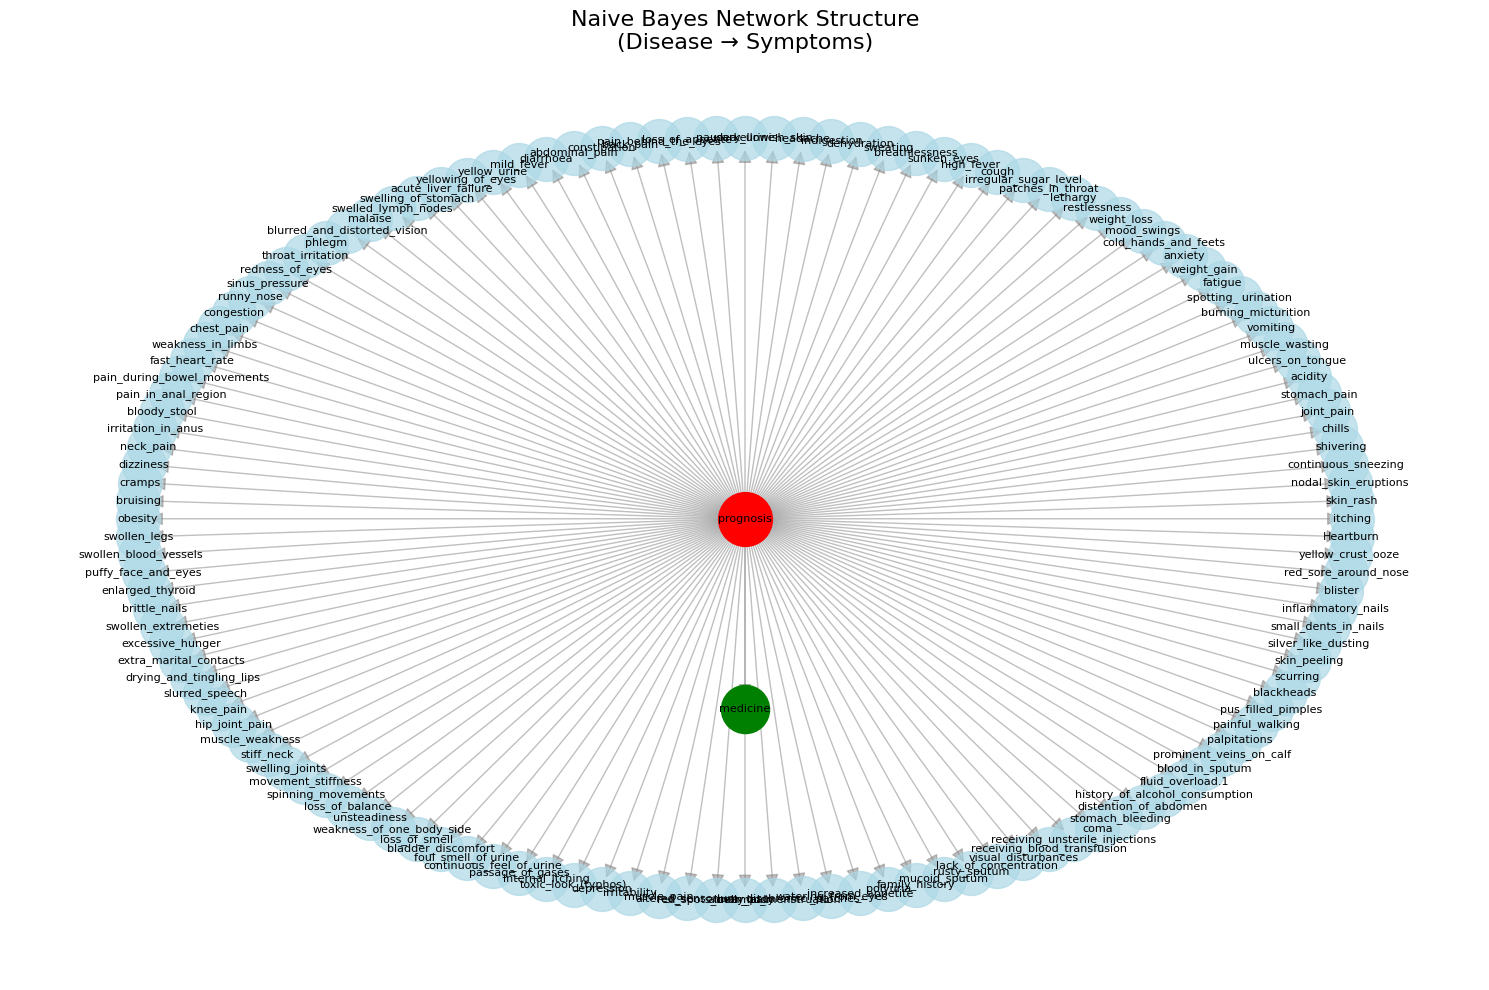

In [30]:
def visualize_network():
    try:
        import matplotlib.pyplot as plt
        import networkx as nx
        
        # Create networkx graph
        G = nx.DiGraph()
        G.add_edges_from(model.edges())
        
        # Create layout
        plt.figure(figsize=(15, 10))
        
        # Position nodes: disease at center, symptoms around it
        pos = {}
        
        # Disease at center
        pos['prognosis'] = (0, 0)
        pos['medicine'] = (0, -1)
        
        # Symptoms in circle around disease
        import math
        n_symptoms = len(symptom_columns)
        for i, symptom in enumerate(symptom_columns):
            angle = 2 * math.pi * i / n_symptoms
            radius = 2
            pos[symptom] = (radius * math.cos(angle), radius * math.sin(angle))
        
        # Draw network
        nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                              node_size=1000, alpha=0.7)
        nx.draw_networkx_nodes(G, pos, nodelist=['prognosis'], 
                              node_color='red', node_size=1500)
        nx.draw_networkx_nodes(G, pos, nodelist=['medicine'], 
                              node_color='green', node_size=1200)
        
        nx.draw_networkx_edges(G, pos, alpha=0.5, arrows=True, 
                              arrowsize=20, edge_color='gray')
        nx.draw_networkx_labels(G, pos, font_size=8)
        
        plt.title("Naive Bayes Network Structure\n(Disease → Symptoms)", fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("Matplotlib and NetworkX required for visualization")
        print("Install with: pip install matplotlib networkx")

# Call this to see visual diagram
visualize_network()

In [21]:
pip install matplotlib networkx

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/8.1 MB 7.1 MB/s eta 0:00:01
   -------------- ------------------------- 2.9/8.1 MB 7.7 MB/s eta 0:00:01
   ----------------------- ---------------- 4.7/8.1 MB 8.3 MB/s eta 0:00:01
   -------------------------------- ------- 6.6/8.1 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 8.3 MB/s  0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 11.6 MB/s  0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ------------------ --------------------- 3.1/7.0 MB 15.5 MB/s eta 0:00:01
   ------------------------------------ --- 6.3/7.0 MB 15.2 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 15.3 MB/s  0:00:

In [31]:
def print_current_structure():
    print("="*80)
    print("CURRENT IMPROVED HIERARCHICAL BAYESIAN NETWORK STRUCTURE")
    print("="*80)
    
    # Basic network info
    print(f"📊 NETWORK OVERVIEW:")
    print(f"   Total nodes: {len(model_improved.nodes())}")
    print(f"   Total edges: {len(model_improved.edges())}")
    print(f"   Network type: Hierarchical (Disease → Systems → Symptoms)")
    
    # Categorize nodes
    disease_nodes = ['prognosis']
    medicine_nodes = ['medicine']
    system_nodes = [node for node in model_improved.nodes() if '_system' in node or '_condition' in node]
    symptom_nodes = [node for node in model_improved.nodes() if node in symptom_columns]
    
    print(f"\n📋 NODE BREAKDOWN:")
    print(f"   Disease nodes: {len(disease_nodes)} → {disease_nodes}")
    print(f"   System nodes: {len(system_nodes)} → {system_nodes}")
    print(f"   Symptom nodes: {len(symptom_nodes)}")
    print(f"   Medicine nodes: {len(medicine_nodes)} → {medicine_nodes}")
    
    # Show hierarchical structure
    print(f"\n🏗️  HIERARCHICAL STRUCTURE:")
    print(f"   Level 1: Disease → Medical Systems")
    for system in system_nodes:
        parents = list(model_improved.predecessors(system))
        print(f"      {parents[0] if parents else 'None'} → {system}")
    
    print(f"\n   Level 2: Medical Systems → Key Symptoms")
    for system in system_nodes:
        children = list(model_improved.successors(system))
        if children:
            print(f"      {system} → {children}")
    
    print(f"\n   Direct: Disease → Medicine")
    print(f"      prognosis → medicine")
    
    # Show all edges
    print(f"\n🔗 ALL NETWORK EDGES:")
    edges = list(model_improved.edges())
    for i, (parent, child) in enumerate(edges, 1):
        print(f"   {i:2d}. {parent} → {child}")
    
    # Show nodes that can be questioned
    leaf_symptoms = get_leaf_symptoms()
    print(f"\n❓ QUESTIONABLE SYMPTOMS (Leaf Nodes):")
    print(f"   Total questionable symptoms: {len(leaf_symptoms)}")
    for i, symptom in enumerate(leaf_symptoms[:10], 1):  # Show first 10
        print(f"   {i:2d}. {symptom}")
    if len(leaf_symptoms) > 10:
        print(f"   ... and {len(leaf_symptoms) - 10} more symptoms")
    
    # Show parent-child relationships in detail
    print(f"\n🌳 DETAILED PARENT-CHILD RELATIONSHIPS:")
    for node in model_improved.nodes():
        parents = list(model_improved.predecessors(node))
        children = list(model_improved.successors(node))
        node_type = "🏥" if node == 'prognosis' else "💊" if node == 'medicine' else "🔧" if any(kw in node for kw in ['_system', '_condition']) else "🩺"
        
        print(f"   {node_type} {node}:")
        print(f"      ⬆️  Parents: {parents if parents else 'None (root node)'}")
        print(f"      ⬇️  Children: {len(children)} nodes {children[:3]}{'...' if len(children) > 3 else ''}")
    
    print("="*80)

# Call this function to see the current structure
print_current_structure()

CURRENT IMPROVED HIERARCHICAL BAYESIAN NETWORK STRUCTURE
📊 NETWORK OVERVIEW:
   Total nodes: 28
   Total edges: 29
   Network type: Hierarchical (Disease → Systems → Symptoms)

📋 NODE BREAKDOWN:
   Disease nodes: 1 → ['prognosis']
   System nodes: 6 → ['respiratory_system', 'digestive_system', 'neurological_system', 'skin_system', 'musculoskeletal_system', 'critical_condition']
   Symptom nodes: 19
   Medicine nodes: 1 → ['medicine']

🏗️  HIERARCHICAL STRUCTURE:
   Level 1: Disease → Medical Systems
      prognosis → respiratory_system
      prognosis → digestive_system
      prognosis → neurological_system
      prognosis → skin_system
      prognosis → musculoskeletal_system
      prognosis → critical_condition

   Level 2: Medical Systems → Key Symptoms
      respiratory_system → ['cough', 'breathlessness', 'chest_pain']
      digestive_system → ['nausea', 'vomiting', 'stomach_pain', 'diarrhoea']
      neurological_system → ['headache', 'dizziness', 'weakness_in_limbs']
      skin_s

❌ Error creating visualization: Node 'fatigue' has no position.


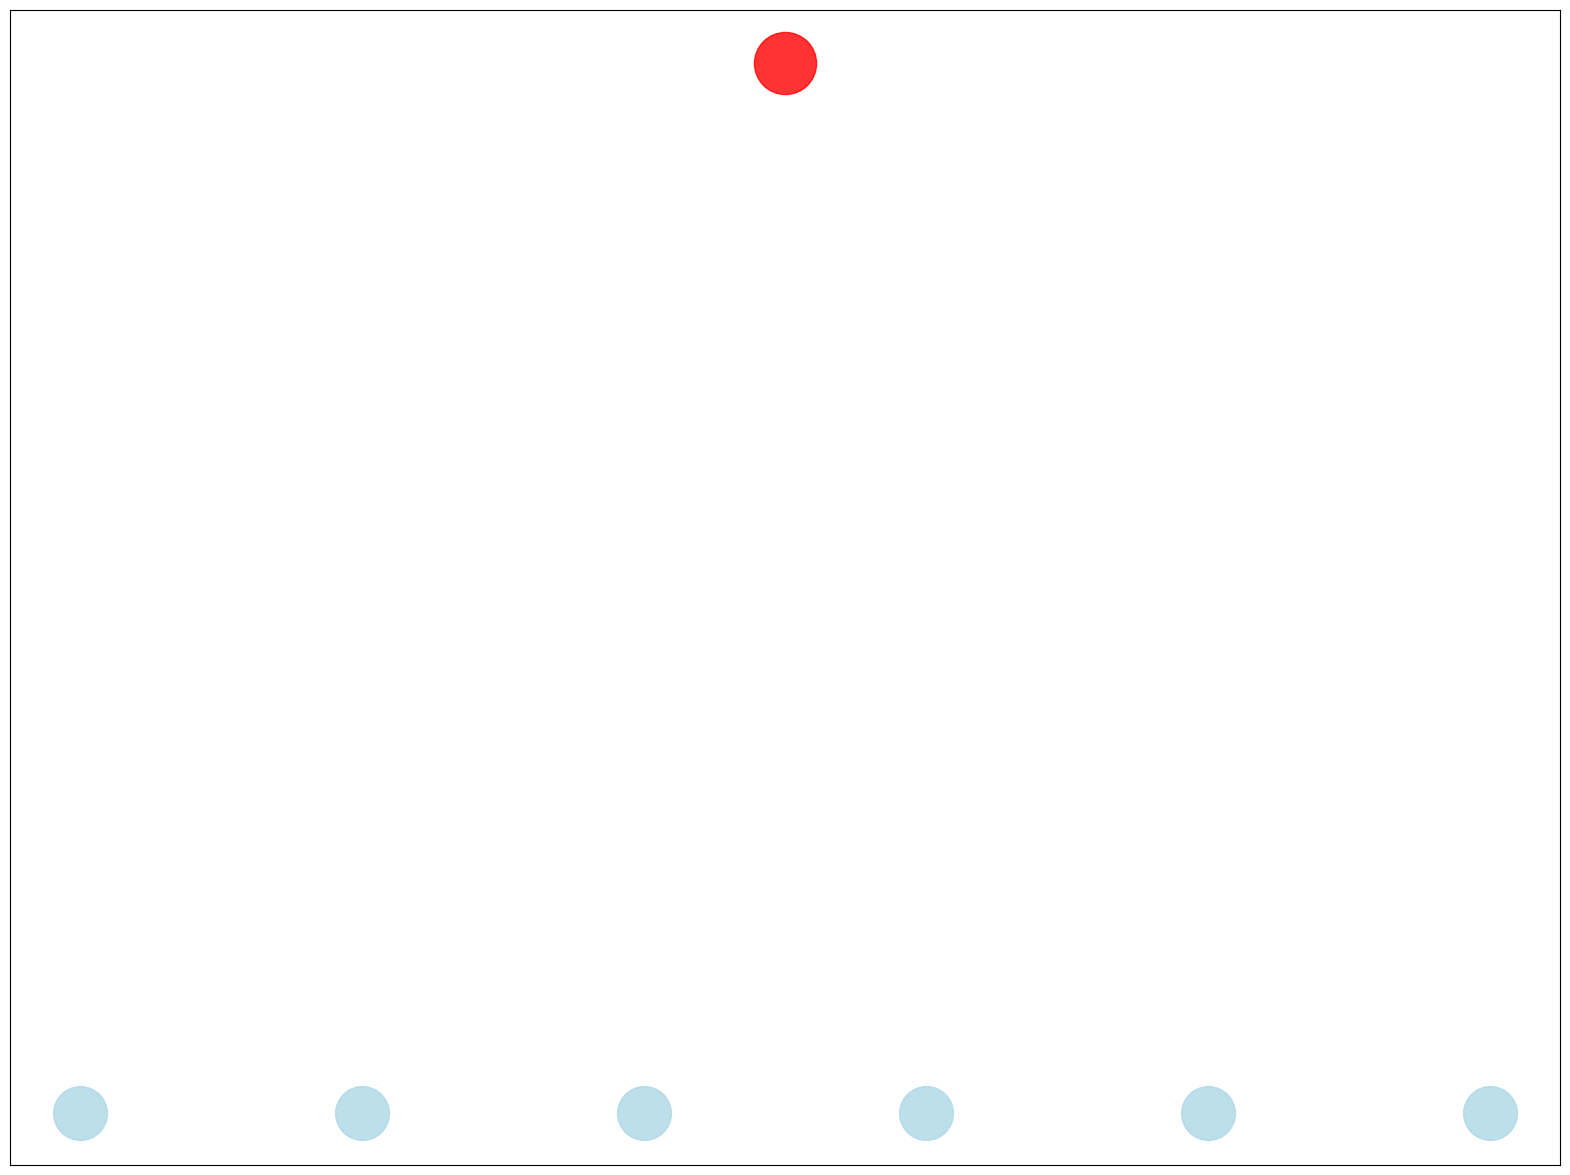

In [32]:
def visualize_improved_network():
    """Visualize the improved hierarchical Bayesian network structure"""
    try:
        import matplotlib.pyplot as plt
        import networkx as nx
        import numpy as np
        
        # Create networkx graph from improved model
        G = nx.DiGraph()
        G.add_edges_from(model_improved.edges())
        
        # Create a larger figure for better visibility
        plt.figure(figsize=(20, 15))
        
        # Categorize nodes
        disease_nodes = ['prognosis']
        medicine_nodes = ['medicine']
        system_nodes = [node for node in model_improved.nodes() if '_system' in node or '_condition' in node]
        symptom_nodes = [node for node in model_improved.nodes() if node in symptom_columns]
        
        # Create hierarchical layout
        pos = {}
        
        # Level 1: Disease at top center
        pos['prognosis'] = (0, 4)
        
        # Level 2: Medical systems in a row below disease
        n_systems = len(system_nodes)
        if n_systems > 0:
            system_x_positions = np.linspace(-6, 6, n_systems)
            for i, system in enumerate(system_nodes):
                pos[system] = (system_x_positions[i], 2)
        
        # Level 3: Symptoms below their respective systems
        y_symptom = 0
        for i, system in enumerate(system_nodes):
            # Get children of this system
            system_children = list(model_improved.successors(system))
            if system_children:
                n_children = len(system_children)
                if n_systems > 0:
                    center_x = system_x_positions[i]
                    child_x_positions = np.linspace(center_x - 1, center_x + 1, n_children)
                    for j, child in enumerate(system_children):
                        pos[child] = (child_x_positions[j], y_symptom)
        
        # Medicine at bottom
        pos['medicine'] = (0, -2)
        
        # Draw nodes with different colors and sizes
        # Disease node (largest, red)
        nx.draw_networkx_nodes(G, pos, nodelist=disease_nodes, 
                              node_color='red', node_size=2000, alpha=0.8)
        
        # System nodes (medium, blue)
        nx.draw_networkx_nodes(G, pos, nodelist=system_nodes, 
                              node_color='lightblue', node_size=1500, alpha=0.8)
        
        # Symptom nodes (small, green)
        nx.draw_networkx_nodes(G, pos, nodelist=symptom_nodes, 
                              node_color='lightgreen', node_size=800, alpha=0.8)
        
        # Medicine node (medium, orange)
        nx.draw_networkx_nodes(G, pos, nodelist=medicine_nodes, 
                              node_color='orange', node_size=1200, alpha=0.8)
        
        # Draw edges with different styles
        # Disease to systems (thick, black)
        disease_to_system_edges = [(u, v) for u, v in G.edges() if u == 'prognosis' and v in system_nodes]
        nx.draw_networkx_edges(G, pos, edgelist=disease_to_system_edges, 
                              edge_color='black', width=3, alpha=0.8, arrows=True, arrowsize=20)
        
        # Systems to symptoms (medium, blue)
        system_to_symptom_edges = [(u, v) for u, v in G.edges() if u in system_nodes and v in symptom_nodes]
        nx.draw_networkx_edges(G, pos, edgelist=system_to_symptom_edges, 
                              edge_color='blue', width=2, alpha=0.6, arrows=True, arrowsize=15)
        
        # Disease to medicine (medium, green)
        disease_to_medicine_edges = [(u, v) for u, v in G.edges() if u == 'prognosis' and v == 'medicine']
        nx.draw_networkx_edges(G, pos, edgelist=disease_to_medicine_edges, 
                              edge_color='green', width=2, alpha=0.8, arrows=True, arrowsize=20)
        
        # Add labels
        # Custom labels for better readability
        labels = {}
        for node in G.nodes():
            if node == 'prognosis':
                labels[node] = 'DISEASE'
            elif node == 'medicine':
                labels[node] = 'MEDICINE'
            elif '_system' in node or '_condition' in node:
                labels[node] = node.replace('_', '\n').upper()
            else:
                labels[node] = node.replace('_', ' ')
        
        nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight='bold')
        
        # Add title and legend
        plt.title("Improved Hierarchical Bayesian Network Structure\n(Disease → Medical Systems → Symptoms)", 
                 fontsize=16, fontweight='bold', pad=20)
        
        # Create legend
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=15, label='Disease'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=12, label='Medical Systems'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=8, label='Symptoms'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Medicine')
        ]
        plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))
        
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Print network statistics
        print("\n" + "="*60)
        print("NETWORK VISUALIZATION STATISTICS")
        print("="*60)
        print(f"📊 Total nodes: {len(G.nodes())}")
        print(f"🔗 Total edges: {len(G.edges())}")
        print(f"🏥 Disease nodes: {len(disease_nodes)}")
        print(f"🔧 System nodes: {len(system_nodes)}")
        print(f"🩺 Symptom nodes: {len(symptom_nodes)}")
        print(f"💊 Medicine nodes: {len(medicine_nodes)}")
        
        print(f"\n🏗️  NETWORK LAYERS:")
        print(f"   Layer 1: Disease (1 node)")
        print(f"   Layer 2: Medical Systems ({len(system_nodes)} nodes)")
        print(f"   Layer 3: Symptoms ({len(symptom_nodes)} nodes)")
        print(f"   Layer 4: Medicine (1 node)")
        
    except ImportError:
        print("❌ Matplotlib and NetworkX required for visualization")
        print("Install with: pip install matplotlib networkx")
    except Exception as e:
        print(f"❌ Error creating visualization: {e}")

# Call this to visualize the improved network
visualize_improved_network()